# Assignment 7

CS4172 Machine Learning Lab

Name: Abhiroop Mukherjee

Enrolment Number: 510519109

## Task 1

Download and preprocess the sentiment analysis dataset from https://www.kaggle.com/snap/amazon-fine-food-reviews. Download the Glove word vectors from http://nlp.stanford.edu/data/glove.6B.zip and extract the 100-dimensional file (glove.6B.100d.txt) from the zipped folder.

## Task 2

Preprocess the review dataset by considering the column “review score” >3 as positive reviews and others as negative reviews. For training on local machine considers 5000 positive and negative reviews each for the training dataset.

Consider 2000 reviews for the test dataset and validation dataset each. Strip the length of each review sentence (number of words) according to your computation availability.

In [1]:
import tensorflow as tf
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # ignore CUDA messages

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')


In [2]:
AMAZON_REVIEW_PATH = "./../ML_DRIVE/Assign_7/Amazon Review/Reviews.csv"
GLOVE_FILE_PATH = "./../ML_DRIVE/Assign_7/glove.6B/glove.6B.100d.txt"

# https://keras.io/examples/nlp/pretrained_word_embeddings/


In [3]:
import pandas as pd

review_df = pd.read_csv(AMAZON_REVIEW_PATH)
review_df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
review_df.columns


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [5]:
columns_to_keep = ['Score', 'Summary', 'Text']

review_df = review_df[columns_to_keep]

review_df.iloc[0:1]


,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [6]:
# merge summary and text (summary in front)

review_df['full_review'] = review_df['Summary'] + ' ' + review_df['Text']
review_df = review_df.drop(['Summary', 'Text'], axis=1)

review_df.iloc[0:1]


,Score,full_review
0,5,Good Quality Dog Food I have bought several of...


In [7]:
# 1 is true, 0 is false
import numpy as np
review_df['review score'] = np.where(review_df.Score > 3, 1, 0)
review_df = review_df.drop(['Score'], axis=1)
review_df


,full_review,review score
0,Good Quality Dog Food I have bought several of...,1
1,Not as Advertised Product arrived labeled as J...,0
2,"""Delight"" says it all This is a confection tha...",1
3,Cough Medicine If you are looking for the secr...,0
4,Great taffy Great taffy at a great price. The...,1
...,...,...
568449,Will not do without Great for sesame chicken.....,1
568450,disappointed I'm disappointed with the flavor....,0
568451,Perfect for our maltipoo These stars are small...,1
568452,Favorite Training and reward treat These are t...,1


In [8]:
# taking 2000 samples for test and validation dataset

test_df = review_df.sample(2000)
val_df = review_df.sample(2000)
review_df = review_df.drop(test_df.index.tolist() + val_df.index.tolist())


In [9]:
# review df does not contain the rows in test_df and val_df
review_df


,full_review,review score
0,Good Quality Dog Food I have bought several of...,1
1,Not as Advertised Product arrived labeled as J...,0
2,"""Delight"" says it all This is a confection tha...",1
3,Cough Medicine If you are looking for the secr...,0
4,Great taffy Great taffy at a great price. The...,1
...,...,...
568449,Will not do without Great for sesame chicken.....,1
568450,disappointed I'm disappointed with the flavor....,0
568451,Perfect for our maltipoo These stars are small...,1
568452,Favorite Training and reward treat These are t...,1


In [10]:
true_df = review_df[review_df['review score'] == 1]
false_df = review_df[review_df['review score'] == 0]

true_df = true_df.sample(5000)
false_df = false_df.sample(5000)

train_df = pd.concat([true_df, false_df]).sort_index()

train_df


,full_review,review score
3,Cough Medicine If you are looking for the secr...,0
60,Better price for this at Target Watch your pri...,0
255,"If you can't handle caffeine, this is not for ...",0
294,Doesn't taste that good but provides you the e...,0
324,Never Arrived So we cancelled the order. It w...,0
...,...,...
568185,Still the best I've ever tasted -- at any pric...,1
568283,nestle chocolate bar i was disapointed since t...,0
568319,"Good Good but not the best, they are really go...",0
568334,Love the honey lemon I am a flight attendant a...,1


In [11]:
# using TextVectorization to index the vocabulary
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(output_sequence_length=100)
vectorizer.adapt(train_df['full_review'].to_list())


In [12]:
# Note the first two are default
# "empty" and "unknown" vocabulary word
vectorizer.get_vocabulary()[:5]


['', '[UNK]', 'the', 'i', 'and']

In [13]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# Now we have the vocabulary encoding of all the words
# in the training dataset in the vectorizer


In [14]:
# converting the glove file,
# where every line is "word coefs" into a dict

import numpy as np

embedding_index = {}

with open(GLOVE_FILE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype=float, sep=" ")
        embedding_index[word] = coefs

print(f"Found {len(embedding_index)} word vectors.")


Found 400000 word vectors.


In [15]:
# now converting it into an embedding layer for using it directly on model
# for more info about embedding layer: https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce#:~:text=Embedding%20layer%20enables%20us%20to,way%20along%20with%20reduced%20dimensions.

num_tokens = len(voc) + 2  # +2 for "empty" and "unknown"
embedding_dim = 100  # cause using glove 100 model
hits = 0  # number of words in vocabulary that are also in the glove map
misses = 0  # number of words in vocabulary that are not in the glove map

# Prepare embedding matrix
# embedding_matrix[i] will be the 100 dimension list
# i is the index made using vocabulary using the vectorizer
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print(f"Converted {hits} word, {misses} misses")


Converted 18371 word, 10581 misses


In [16]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Embedding

glove_embedding = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


In [17]:
# Now the basic idea
# word -> encoded number using vectorizer ->
# convert to 100d vector using embedding layer -> neural network


In [18]:
x_train = vectorizer(
    np.array(
        [[s] for s in train_df['full_review'].tolist()]
    )
).numpy()

x_val = vectorizer(
    np.array(
        [[s] for s in val_df['full_review'].tolist()]
    )
).numpy()

x_test = vectorizer(
    np.array(
        [[s] for s in test_df['full_review'].tolist()]
    )
).numpy()


In [19]:
from tensorflow.keras.utils import to_categorical


y_train = to_categorical(train_df['review score'].tolist())
y_val = to_categorical(val_df['review score'].tolist())
y_test = to_categorical(test_df['review score'].tolist())


In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import \
    Dense, Input, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import time
from keras.utils.layer_utils import count_params


def train_model(
    x_train,
    y_train,
    x_val,
    y_val,
    rnn_type: str,
    num_rnn_layers: int,
    rnn_layer_unit: int,
    embedding_layer_type: str,
    num_epochs: int = 30
):
    model = Sequential()
    model.add(Input(shape=(None, ), dtype="int64"))

    if embedding_layer_type == 'glove':
        model.add(glove_embedding)
    else:
        raise Exception('Error: undefined embedding_layer_type')

    for _ in range(0, num_rnn_layers):
        if rnn_type == 'lstm':
            model.add(LSTM(rnn_layer_unit, activation='relu'))
        elif rnn_type == 'gru':
            model.add(GRU(rnn_layer_unit, activation='relu'))
        else:
            raise Exception('Error: undefined rnn_type')

    model.add(Dense(2, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy", metrics=["accuracy"]
    )

    callback = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]

    start_time = time.time()
    history = model.fit(
        x_train,
        y_train,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks= callback,
        verbose=0
    )
    train_time = time.time() - start_time

    start_time = time.time()
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    infer_time = time.time() - start_time

    num_param = count_params(model.trainable_weights)

    plt.plot(
        history.history['loss'],
        label=f"{num_rnn_layers} layers;{rnn_type};{rnn_layer_unit} units;{embedding_layer_type} embedding"
    )

    return num_param, val_loss, val_acc, train_time, infer_time


In [21]:
result_df = pd.DataFrame(columns=[
    'RNN Type',
    'RNN Layer',
    'RNN Size',
    'Embedding Layer',
    'Num Params',
    'Val Loss',
    'Val Accuracy',
    'Train Time (s)',
    'Infer Time (s)'
])

## Task 3

Train RNN model with the FC layer applied in the final hidden layer output using the following parameter

| Sr. No: | RNN  | RNN Layer | RNN Size | Activation | FC Layer | Embedding Layer |
|---------|------|-----------|----------|------------|----------|-----------------|
| 1       | LSTM | 1         | 64       | Relu       | 1        | Glove           |
| 2       | GRU  | 1         | 64       | Relu       | 1        | Glove           |


1 layers;lstm;64 units;glove embedding => 42370 Params;val_loss=0.6780754923820496;val_acc=0.7, train_time=96.38s;infer_time=0.46s
1 layers;gru;64 units;glove embedding => 32002 Params;val_loss=0.28754258155822754;val_acc=0.88, train_time=173.69s;infer_time=0.42s


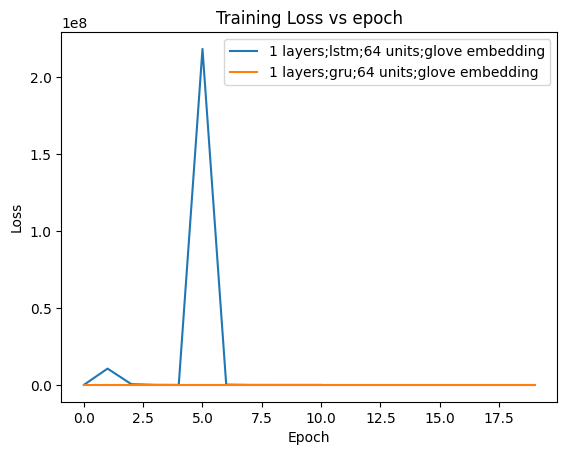

In [22]:
rnn_types = ['lstm', 'gru']
num_rnn_layers=1
rnn_layer_unit=64
embedding_layer_type='glove'


for rnn_type in rnn_types:
    num_param, val_loss, val_acc, train_time, infer_time = train_model(
        x_train,
        y_train,
        x_val,
        y_val,
        rnn_type=rnn_type,
        num_rnn_layers=num_rnn_layers,
        rnn_layer_unit=rnn_layer_unit,
        embedding_layer_type=embedding_layer_type,
    )

    print(f"{num_rnn_layers} layers;{rnn_type};{rnn_layer_unit} units;{embedding_layer_type} embedding => {num_param} Params;val_loss={val_loss};val_acc={round(val_acc,2)}, train_time={round(train_time,2)}s;infer_time={round(infer_time,2)}s")

    result_df.loc[len(result_df.index)] = [
        rnn_type,
        num_rnn_layers,
        rnn_layer_unit,
        embedding_layer_type,
        num_param, 
        val_loss, 
        val_acc, 
        train_time, 
        infer_time
    ]

plt.rcParams['figure.figsize'] = [12, 5]
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title(f'Training Loss vs epoch')
plt.show()


In [23]:
result_df

,RNN Type,RNN Layer,RNN Size,Embedding Layer,Num Params,Val Loss,Val Accuracy,Train Time (s),Infer Time (s)
0,lstm,1,64,glove,42370,0.678075,0.7045,96.377602,0.461738
1,gru,1,64,glove,32002,0.287543,0.8790,173.693413,0.417338


In [24]:
best_rnn_type = result_df.sort_values(
    by=['Val Accuracy', 'Val Loss'],
    ascending=[False, True]
)['RNN Type'].iloc[0]

best_rnn_type

'gru'